In [1]:
%load_ext autoreload
%autoreload 2

# Synthetic Data

## Generate

In [2]:
from faim.data_preparation.synthetic import NormalSyntheticGroupedDatasetBuilder
import numpy as np
from numpy.random import PCG64, Generator


random_generator = Generator(PCG64(4))
group_names=["privileged", "disadvantaged"]
synth_data_builder = NormalSyntheticGroupedDatasetBuilder(
    group_names=group_names,
    n_by_group=[50000, 50000],
    truth_prediction_means_by_group=[np.array([1, 2]), np.array([-1, -3]),],
    truth_prediction_correlation_matrixs_by_group=[
        np.array([[1, 0.8], [0.8, 1]]),
        np.array([[1, 0.8], [0.8, 1]]),
    ],
    random_generator=random_generator
)
synth_data = synth_data_builder.build()
synth_data.head()

,uuid,group,true_score,pred_score,true_label,pred_label
37946,61690248984788657218284987529151945635,0,0.897985,1.856003,1,1
4589,313863767218095658908289679367809502023,1,-0.221229,-2.008019,0,0
3166,54831838391621729574676657023165588603,0,2.361094,3.257432,1,1
17204,227503409615892428828483690159797022919,1,-0.124138,-2.095224,0,0
46899,61559048902492163868108324151274561739,1,-1.730384,-3.377135,0,0


## Figure 1

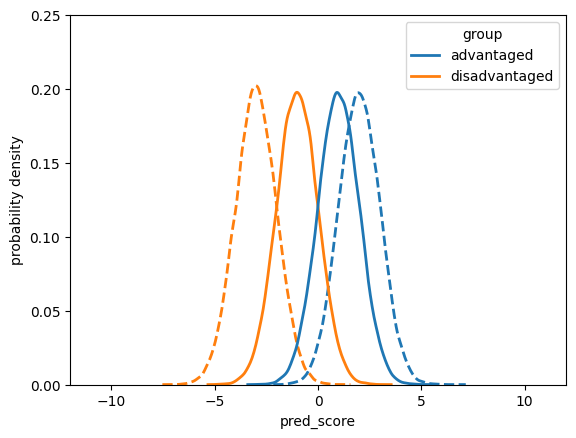

In [38]:
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("tab10")

plot_data = deepcopy(synth_data)
plot_data["group"] = plot_data.group.map(lambda idx: group_names[idx])

fig, ax = plt.subplots()
sns.kdeplot(data=plot_data, x="pred_score", hue="group", linestyle="--", linewidth=2, ax=ax)
sns.kdeplot(data=plot_data, x="true_score", hue="group", linestyle="-", linewidth=2, ax=ax)
_ = ax.set_ylabel("probability density")
_ = ax.set_xlim([-12, 12])
_ = ax.set_ylim([0, 0.25])

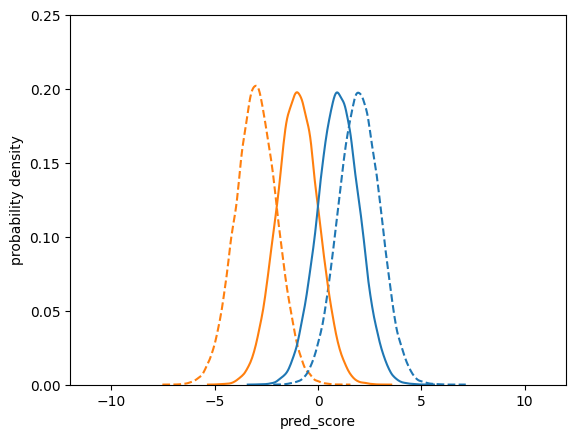

In [4]:
ax.get_legend().remove()
fig

In [5]:
fig.savefig("figures/figure1.svg", format="svg")

## Figure 2

In [6]:
synth_data

,uuid,group,true_score,pred_score,true_label,pred_label
37946,61690248984788657218284987529151945635,0,0.897985,1.856003,1,1
4589,313863767218095658908289679367809502023,1,-0.221229,-2.008019,0,0
3166,54831838391621729574676657023165588603,0,2.361094,3.257432,1,1
17204,227503409615892428828483690159797022919,1,-0.124138,-2.095224,0,0
46899,61559048902492163868108324151274561739,1,-1.730384,-3.377135,0,0
...,...,...,...,...,...,...
7930,98142215448262867221136871184877839740,1,-1.212780,-2.572315,0,0
7509,28380517086228653308890757865154932482,1,-1.531099,-2.926980,0,0
37039,163954096030171587036850869378468495280,1,-0.558287,-1.985790,0,0
2260,59915184570529509212379074497961766369,0,0.549074,0.871799,1,1


# Synth From Paper

## Get Fair Scores

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load paper data (remove truncated data - it's calculated later anyways)
synth_data_from_paper_filepath = Path("../prepared-data/synthetic/2groups/2022-01-12/dataset.csv")
data = pd.read_csv(synth_data_from_paper_filepath)

group_names = {0: "advantaged", 1: "disadvantaged"}
pred_score_column = "pred_score"
score_stepsize = 0.1
thetas = {0: np.array([1, 0, 0]), 1: np.array([1, 0, 0])}
optimal_transport_regularization = 0.001
plot_dir = Path("../results/synthetic/2groups/2022-01-12-notebook/")

In [8]:
from faim.algorithm.faim import FairInterpolationMethod

fair_interpolation_method = FairInterpolationMethod(
    rawData=data,
    group_names=group_names,
    pred_score_column=pred_score_column,
    score_stepsize=score_stepsize,
    thetas=thetas,
    regForOT=optimal_transport_regularization,
    plot_dir=plot_dir,
    plot=False,
)
results = fair_interpolation_method.run()

    1|9.254060e-01|
   11|2.867910e-01|
   21|5.811975e-02|
   31|1.135057e-02|
   41|2.212253e-03|
   51|4.307819e-04|
Sum of barycenter between groups for condition groundTruthLabel=0: 0.999999997079619
    1|9.284266e-01|
   11|3.135971e-01|
   21|6.653845e-02|
   31|1.354469e-02|
   41|2.739430e-03|
   51|5.534922e-04|
   61|1.118069e-04|
Sum of barycenter between groups for condition groundTruthLabel=1: 0.9999999997886343


/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:258: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, fairScore in fairScores.iteritems():
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:265: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw = raw.groupby(["group"], as_index=Fa

    1|7.820441e-01|
   11|4.357995e-01|
   21|2.263641e-01|
   31|1.348808e-01|
   41|8.899632e-02|
   51|6.472798e-02|
   61|5.283056e-02|
   71|4.632999e-02|
   81|4.219433e-02|
   91|3.917434e-02|
  101|3.669457e-02|
  111|3.448174e-02|
  121|3.241191e-02|
  131|3.043527e-02|
  141|2.853694e-02|
  151|2.671674e-02|
  161|2.497914e-02|
  171|2.332865e-02|
  181|2.176806e-02|
  191|2.029803e-02|
  201|1.891742e-02|
  211|1.762396e-02|
  221|1.641425e-02|
  231|1.528426e-02|
  241|1.422984e-02|
  251|1.324697e-02|
  261|1.233152e-02|
  271|1.147900e-02|
  281|1.068534e-02|
  291|9.946661e-03|
  301|9.259277e-03|
  311|8.619700e-03|
  321|8.024637e-03|
  331|7.470998e-03|
  341|6.955976e-03|
  351|6.476868e-03|
  361|6.031030e-03|
  371|5.616122e-03|
  381|5.229966e-03|
  391|4.870541e-03|
  401|4.535970e-03|
  411|4.224509e-03|
  421|3.934541e-03|
  431|3.664563e-03|
  441|3.413182e-03|
  451|3.179103e-03|
  461|2.961124e-03|
  471|2.758127e-03|
  481|2.569076e-03|
  491|2.393006e-03|


/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:258: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, fairScore in fairScores.iteritems():
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:258: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, fairScore in fairScores.iteritems():
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:265: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve 

## Boundary

<Axes: xlabel='pred_score_truncated'>

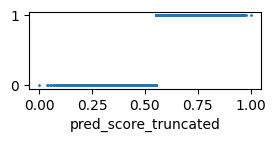

In [9]:
results.plot(x="pred_score_truncated", y="predictedLabel", style='.', markersize=2, figsize=(3, 1), legend=False)

In [10]:
def find_boundary(results) -> float:
    return (
        results[results.predictedLabel==0].pred_score_truncated.max()
        + results[results.predictedLabel==1].pred_score_truncated.min()
    ) / 2
    

In [11]:
find_boundary(results)

0.5507246376811594

## Results Plots - Calibration Condition

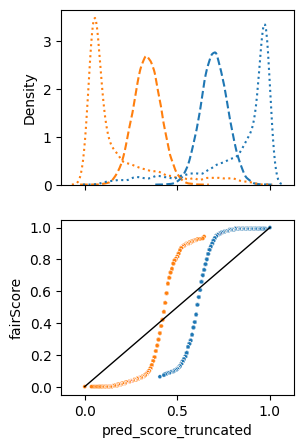

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("tab10")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(3, 5))

sns.kdeplot(data=results, x="pred_score_truncated", hue="group", linestyle="--", ax=ax1)
sns.kdeplot(data=results, x="fairScore", hue="group", linestyle=":", ax=ax1)

sns.scatterplot(data=results, x="pred_score_truncated", y="fairScore", hue="group", s=8, ax=ax2)
plt.plot([0, 1], [0, 1], 'k-', linewidth=1)

for ax in (ax1, ax2):
    ax.get_legend().remove()

## All Conditions

In [15]:
thetas_by_condition = [
    {0: np.array([1, 0, 0]), 1: np.array([1, 0, 0])},
    {0: np.array([0, 1, 0]), 1: np.array([0, 1, 0])},
    {0: np.array([0, 0, 1]), 1: np.array([0, 0, 1])},
    {0: np.array([1, 1, 1]), 1: np.array([1, 1, 1])},
]
plot_dir_by_condition = [
    Path("../results/synthetic/2groups/2022-01-12-notebook/1,0,0,1,0,0/"),
    Path("../results/synthetic/2groups/2022-01-12-notebook/0,1,0,0,1,0/"),
    Path("../results/synthetic/2groups/2022-01-12-notebook/0,0,1,0,0,1/"),
    Path("../results/synthetic/2groups/2022-01-12-notebook/1,1,1,1,1,1/"),
]

results_by_condition = []
for thetas, plot_dir in zip(thetas_by_condition, plot_dir_by_condition):
    fair_interpolation_method = FairInterpolationMethod(
        rawData=data,
        group_names=group_names,
        pred_score_column=pred_score_column,
        score_stepsize=score_stepsize,
        thetas=thetas,
        regForOT=optimal_transport_regularization,
        plot_dir=plot_dir,
        plot=False,
    )
    results_by_condition.append(fair_interpolation_method.run())

    1|9.254060e-01|
   11|2.867910e-01|
   21|5.811975e-02|
   31|1.135057e-02|
   41|2.212253e-03|
   51|4.307819e-04|
Sum of barycenter between groups for condition groundTruthLabel=0: 0.999999997079619
    1|9.284266e-01|
   11|3.135971e-01|
   21|6.653845e-02|
   31|1.354469e-02|
   41|2.739430e-03|
   51|5.534922e-04|
   61|1.118069e-04|
Sum of barycenter between groups for condition groundTruthLabel=1: 0.9999999997886343


/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:267: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  fairEdges = sorted(raw[newScores_colName].unique

    1|7.820441e-01|
   11|4.357995e-01|
   21|2.263641e-01|
   31|1.348808e-01|
   41|8.899632e-02|
   51|6.472798e-02|
   61|5.283056e-02|
   71|4.632999e-02|
   81|4.219433e-02|
   91|3.917434e-02|
  101|3.669457e-02|
  111|3.448174e-02|
  121|3.241191e-02|
  131|3.043527e-02|
  141|2.853694e-02|
  151|2.671674e-02|
  161|2.497914e-02|
  171|2.332865e-02|
  181|2.176806e-02|
  191|2.029803e-02|
  201|1.891742e-02|
  211|1.762396e-02|
  221|1.641425e-02|
  231|1.528426e-02|
  241|1.422984e-02|
  251|1.324697e-02|
  261|1.233152e-02|
  271|1.147900e-02|
  281|1.068534e-02|
  291|9.946661e-03|
  301|9.259277e-03|
  311|8.619700e-03|
  321|8.024637e-03|
  331|7.470998e-03|
  341|6.955976e-03|
  351|6.476868e-03|
  361|6.031030e-03|
  371|5.616122e-03|
  381|5.229966e-03|
  391|4.870541e-03|
  401|4.535970e-03|
  411|4.224509e-03|
  421|3.934541e-03|
  431|3.664563e-03|
  441|3.413182e-03|
  451|3.179103e-03|
  461|2.961124e-03|
  471|2.758127e-03|
  481|2.569076e-03|
  491|2.393006e-03|


/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:267: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous beh

    1|9.254060e-01|
   11|2.867910e-01|
   21|5.811975e-02|
   31|1.135057e-02|
   41|2.212253e-03|
   51|4.307819e-04|
Sum of barycenter between groups for condition groundTruthLabel=0: 0.999999997079619
    1|9.284266e-01|
   11|3.135971e-01|
   21|6.653845e-02|
   31|1.354469e-02|
   41|2.739430e-03|
   51|5.534922e-04|
   61|1.118069e-04|
Sum of barycenter between groups for condition groundTruthLabel=1: 0.9999999997886343


/Users/aloosley/Repos/faim/faim/algorithm/faim.py:267: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  fairEdges = sorted(raw[newScores_colName].unique())
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index +

    1|7.848907e-01|
   11|4.539278e-01|
   21|2.520455e-01|
   31|1.579102e-01|
   41|1.103142e-01|
   51|8.340670e-02|
   61|6.752066e-02|
   71|5.775627e-02|
   81|5.125646e-02|
   91|4.645868e-02|
  101|4.258865e-02|
  111|3.925366e-02|
  121|3.623507e-02|
  131|3.347005e-02|
  141|3.091992e-02|
  151|2.857053e-02|
  161|2.641878e-02|
  171|2.445552e-02|
  181|2.266841e-02|
  191|2.103639e-02|
  201|1.953111e-02|
  211|1.813412e-02|
  221|1.683223e-02|
  231|1.561700e-02|
  241|1.448298e-02|
  251|1.342616e-02|
  261|1.244300e-02|
  271|1.153000e-02|
  281|1.068353e-02|
  291|9.899843e-03|
  301|9.175122e-03|
  311|8.505518e-03|
  321|7.887227e-03|
  331|7.316654e-03|
  341|6.790678e-03|
  351|6.305224e-03|
  361|5.857077e-03|
  371|5.443228e-03|
  381|5.060882e-03|
  391|4.707452e-03|
  401|4.380560e-03|
  411|4.078021e-03|
  421|3.797839e-03|
  431|3.538190e-03|
  441|3.297413e-03|
  451|3.073991e-03|
  461|2.866548e-03|
  471|2.673825e-03|
  481|2.494678e-03|
  491|2.328063e-03|


/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:267: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous beh

    1|9.284266e-01|
   11|3.135971e-01|
   21|6.653845e-02|
   31|1.354469e-02|
   41|2.739430e-03|
   51|5.534922e-04|
   61|1.118069e-04|
Sum of barycenter between groups for condition groundTruthLabel=1: 0.9999999997886343


/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:267: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  fairEdges = sorted(raw[newScores_colName].unique

    1|7.909518e-01|
   11|5.056634e-01|
   21|2.994154e-01|
   31|1.767739e-01|
   41|1.116079e-01|
   51|7.522656e-02|
   61|5.289886e-02|
   71|3.845774e-02|
   81|2.854467e-02|
   91|2.151998e-02|
  101|1.635922e-02|
  111|1.250790e-02|
  121|9.601872e-03|
  131|7.393257e-03|
  141|5.706808e-03|
  151|4.411133e-03|
  161|3.412981e-03|
  171|2.642665e-03|
  181|2.047389e-03|
  191|1.586915e-03|
  201|1.230439e-03|
  211|9.543063e-04|
  221|7.403066e-04|
  231|5.743968e-04|
  241|4.457319e-04|
  251|3.459270e-04|
  261|2.684940e-04|
  271|2.084090e-04|
  281|1.617796e-04|
  291|1.255890e-04|
    1|8.116180e-01|
   11|5.049038e-01|
   21|3.055282e-01|
   31|2.010513e-01|
   41|1.448621e-01|
   51|1.102505e-01|
   61|8.823587e-02|
   71|7.386474e-02|
   81|6.449296e-02|
   91|5.795298e-02|
  101|5.298476e-02|
  111|4.887159e-02|
  121|4.530303e-02|
  131|4.218212e-02|
  141|3.943245e-02|
  151|3.690036e-02|
  161|3.445825e-02|
  171|3.207177e-02|
  181|2.976177e-02|
  191|2.755715e-02|


/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:267: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous beh

    1|9.284266e-01|
   11|3.135971e-01|
   21|6.653845e-02|
   31|1.354469e-02|
   41|2.739430e-03|
   51|5.534922e-04|
   61|1.118069e-04|
Sum of barycenter between groups for condition groundTruthLabel=1: 0.9999999997886343
    1|7.860249e-01|
   11|4.633373e-01|
   21|2.531054e-01|
   31|1.481974e-01|
   41|9.776213e-02|
   51|7.085719e-02|
   61|5.589230e-02|
   71|4.683186e-02|
   81|4.070222e-02|
   91|3.609373e-02|
  101|3.234326e-02|
  111|2.913992e-02|
  121|2.633319e-02|
  131|2.384314e-02|
  141|2.161907e-02|
  151|1.962278e-02|
  161|1.782332e-02|
  171|1.619579e-02|
  181|1.472052e-02|
  191|1.338193e-02|
  201|1.216720e-02|
  211|1.106524e-02|
  221|1.006602e-02|
  231|9.160276e-03|
  241|8.339398e-03|
  251|7.595372e-03|
  261|6.920811e-03|
  271|6.308949e-03|
  281|5.753637e-03|
  291|5.249314e-03|
  301|4.790980e-03|
  311|4.374147e-03|
  321|3.994799e-03|
  331|3.649338e-03|
  341|3.334549e-03|
  351|3.047551e-03|
  361|2.785760e-03|
  371|2.546858e-03|
  381|2.328758

/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/util/util.py:43: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_norm_vec = np.reciprocal(norm_vec)
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:260: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  range_right = self._binEdges[index + 1]
/Users/aloosley/Repos/faim/faim/algorithm/faim.py:267: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous beh

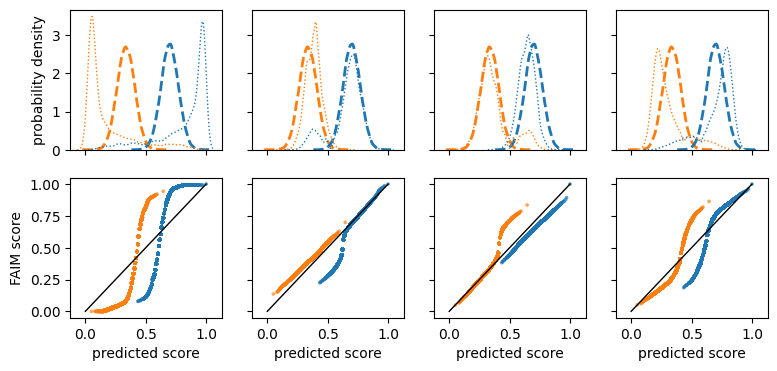

In [81]:
sns.color_palette("tab10")
fig, axes = plt.subplots(2, 4, sharex=True, sharey="row", figsize=(9, 4))

for condition_idx, results in enumerate(results_by_condition):
    ax1, ax2 = axes[:, condition_idx]

    sns.kdeplot(data=results, x="pred_score_truncated", hue="group", linestyle="--", linewidth=2, ax=ax1)
    # sns.histplot(data=results, x="pred_score_truncated", hue="group", ax=ax1, )
    sns.kdeplot(data=results, x="fairScore", hue="group", linestyle=":", linewidth=1, ax=ax1)
    # sns.histplot(data=results, x="fairScore", hue="group", ax=ax1)
    ax1.set_xlabel("score")
    ax1.set_ylabel("probability density")
    
    ax2.plot([0, 1], [0, 1], 'k-', linewidth=1)
    sns.scatterplot(
        # Take every fourth point 
        #  (huge compression for SVG without compremising interpretation, and inkscape hangs if svg too big)
        data=results.iloc[::4, :], 
        x="pred_score_truncated", y="fairScore", hue="group", s=7, ax=ax2, linewidth=0, alpha = 0.7
    )
    ax2.set_xlabel("predicted score")
    ax2.set_ylabel("FAIM score")

    for ax in (ax1, ax2):
        ax.get_legend().remove()

In [82]:
fig.savefig("figures/figure2.svg", format="svg")

In [41]:
results

,group,uuid,true_score,pred_score,groundTruthLabel,predictedLabel,pred_score_truncated,SA,SB,SC,fairScore
0,0,223704946252196807091298734533014967204,3.741460,6.142062,1,1,1.000000,1.0,1.000000,1.000000,1.000000
1,0,224541773764000480556563320628354434199,5.053919,5.872418,1,1,0.978261,1.0,0.978261,0.872033,0.975831
2,0,153592159237664263961470057929324881735,3.416175,5.790487,1,1,0.971014,1.0,0.971014,0.860298,0.963684
3,0,248500439509309554877149774539242102947,4.031626,5.756255,1,1,0.971014,1.0,0.971014,0.860298,0.963684
4,0,288410677808488351912798103878192180675,3.832034,5.740493,1,1,0.971014,1.0,0.971014,0.860298,0.963684
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,201088466828612981931606012330630679125,-4.590110,-6.873775,0,0,0.057971,0.0,0.172662,0.057971,0.050543
99996,1,156639998875615619830725047577634453146,-4.513462,-6.925664,0,0,0.050725,0.0,0.169607,0.050725,0.050360
99997,1,158639963285064233212704982766127245893,-4.203670,-7.077972,0,0,0.043478,0.0,0.163976,0.043478,0.043725
99998,1,72590190118598787538214824933143546660,-4.139700,-7.095118,0,0,0.036232,0.0,0.155185,0.036232,0.038042
